In [1]:
import imblearn

import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Loading of data and splitting in groups according to images

In [15]:
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
#filename = "feature-tables/train-data_1527086478.csv" # no LBP
filename = "feature-tables/train-data_1527093743.csv" # with LBP

dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the featur from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data_raw = np.vstack((dataset01_data, dataset02_data))
all_labels_raw = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data_raw = preprocessing.StandardScaler().fit_transform(all_data_raw)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

dataset_df1.head()

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3269
Number of regions in dataset 02: 3107


,perimeter,area,circularity,ac,shape_factor,mean NRL,SD NRL,Ratio SD NRL and mean RL,entropy NRL,NCPS,...,LBP992,LBP993,LBP994,LBP995,LBP996,LBP997,LBP998,LBP999,class_id,img_name
78,11915.436843,471594.5,23.957491,19684.636019,301.058717,0.483254,0.213549,0.000467,7.449049,0.000577,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
79,1456.835567,25008.5,6.753417,3703.088402,84.865940,0.469930,0.218902,0.001773,5.244906,0.005927,...,0.04,0.24,0.16,0.08,0.04,0.04,0.00,0.12,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
80,552.568541,12930.0,1.879161,6880.731345,23.614230,0.691730,0.110095,0.001784,4.509496,0.006628,...,0.28,0.28,0.20,0.12,0.00,0.00,0.00,0.00,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
81,489.254833,8677.0,2.195284,3952.563082,27.586757,0.616047,0.136988,0.002801,4.318305,0.006962,...,0.12,0.16,0.04,0.12,0.00,0.04,0.04,0.16,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
82,412.183765,6257.5,2.160583,2896.208448,27.150692,0.652244,0.192145,0.004071,4.048747,0.003196,...,0.28,0.24,0.04,0.16,0.00,0.00,0.04,0.12,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON


# Data Augmentation with over sampling

In [16]:
# Parameters for features without LBP
oversampling_kernel = SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind='svm'))

dataset01_data_resampled, dataset01_labels_resampled = oversampling_kernel.fit_sample(dataset01_data, dataset01_labels)
dataset02_data_resampled, dataset02_labels_resampled = oversampling_kernel.fit_sample(dataset02_data, dataset02_labels)
all_data = np.vstack((dataset01_data_resampled, dataset02_data_resampled))
all_labels = np.concatenate((dataset01_labels_resampled, dataset02_labels_resampled),axis=0)

print(f"Data set 1 resampled {len(dataset01_labels_resampled)}")
print(f"Data set 2 resampled {len(dataset02_labels_resampled)}")
print(f"Number of masses, data set 1 {sum(dataset01_labels_resampled > 0)}")
print(f"Number of masses, data set 2 {sum(dataset02_labels_resampled > 0)}")

Data set 1 resampled 6440
Data set 2 resampled 4890
Number of masses, data set 1 3220
Number of masses, data set 2 1844


# Grid Search

In [4]:
# Fit and tune the algorithm

clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

parameters = {'n_estimators': [35, 75, 101, 301, 501, 1001],
              'max_features': ['log2', 'sqrt'],
              'max_depth': [5, 10, 20],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
             }
# Run the grid search
grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                        scoring='roc_auc',
                        refit=True,
                        n_jobs=2,
                        pre_dispatch='2*n_jobs',
                        cv=2,
                        verbose=2,
                        return_train_score=False)

grid_obj = grid_obj.fit(all_data, all_labels)

# # Set the clf to the best combination of parameters
#clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
#clf.fit(x_train, y_train)

grid_obj.fit(all_data, all_labels)
print(grid_obj.best_score_, grid_obj.best_params_)

Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   1.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=35, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   2.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=101 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   2.0s
[CV] max_depth=5, max

KeyboardInterrupt: 

In [8]:
print(grid_obj.best_score_, grid_obj.best_params_)

0.9957692670208536 {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1001}


# Augmented vs original data

## Classifiers with original parameters

In [4]:
# 85% of masses detected, 85% accuracy, f1_score=20%, mathew_coef=25%
# Parameter selection by me, fit to the train data set firts

# dataset01_data, dataset01_labels
# dataset02_data, dataset02_labels
clf_aia_01 = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=10, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_aia_01.fit(dataset01_data, dataset01_labels)

# Now fit to the test data set, classifier the same
clf_aia_02 = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=10, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_aia_02.fit(dataset02_data, dataset02_labels)

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: Runtim

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=10, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [5]:
prob_aia_01 = clf_aia_01.predict_proba(dataset02_data)
pred_aia_01 = clf_aia_01.predict(dataset02_data)

prob_aia_02 = clf_aia_02.predict_proba(dataset01_data)
pred_aia_02 = clf_aia_02.predict(dataset01_data)

prob_aia = np.vstack((prob_aia_01, prob_aia_02))
pred_aia = np.concatenate((pred_aia_01, pred_aia_02), axis=0)

labels = np.concatenate((dataset02_labels, dataset01_labels))

# Optimal Classifier

In [12]:
# dataset01_data_resampled, dataset01_labels_resampled
# dataset02_data_resampled, dataset02_labels_resampled

# optimal parameters
#{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
clf_rs_01 = RandomForestClassifier(n_estimators=1001,
                             max_features='log2',
                             min_samples_leaf=2,
                             min_samples_split=5,
                             max_depth=20,
                             class_weight='balanced',
                             oob_score=True)

# clf_rs_01 = RandomForestClassifier(n_estimators=1000, #500
#                              max_features='sqrt',
#                              min_samples_leaf=50,
#                              class_weight='balanced',
#                              oob_score=True)

clf_rs_01.fit(dataset01_data_resampled, dataset01_labels_resampled)

# Now fit to the test data set, classifier the same
clf_rs_02 = RandomForestClassifier(n_estimators=1001,
                             max_features='log2',
                             min_samples_leaf=2,
                             min_samples_split=5,
                             max_depth=20,
                             class_weight='balanced',
                             oob_score=True)

# clf_rs_02 = RandomForestClassifier(n_estimators=1000, #500
#                              max_features='sqrt',
#                              min_samples_leaf=50,
#                              class_weight='balanced',
#                              oob_score=True)

clf_rs_02.fit(dataset02_data_resampled, dataset02_labels_resampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [13]:
prob_rs_01 = clf_rs_01.predict_proba(dataset02_data_resampled)
pred_rs_01 = clf_rs_01.predict(dataset02_data_resampled)

prob_rs_02 = clf_rs_02.predict_proba(dataset01_data_resampled)
pred_rs_02 = clf_rs_02.predict(dataset01_data_resampled)

prob_rs = np.vstack((prob_rs_01, prob_rs_02))
pred_rs = np.concatenate((pred_rs_01, pred_rs_02), axis=0)

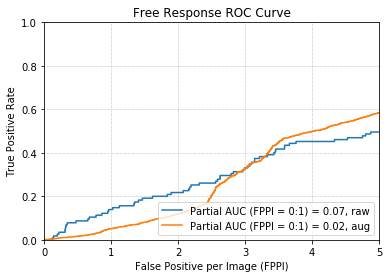

In [14]:
# Counts to adjust the TPR and to create the False Positive per Image
_, counts = np.unique(labels, return_counts=True)
num_img = 410
num_pos_img = 115
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img
pos_reg_per_pimg = pos_reg / num_pos_img

# all_labels - for reshaped data
classification.get_roc((labels, all_labels),
                       (prob_aia, prob_rs),
                       neg_reg_per_img,
                       pos_reg_per_pimg,
                       ('raw', 'aug'))